In [1]:
#Money Flow Index

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


Price,Adj Close,Close,High,Low,Open,Volume,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,,
2021-07-27,414.858643,439.010010,439.940002,435.989990,439.910004,67397100,438.313334,2.954105e+10,0.000000e+00,2.954105e+10,49.014131,0.0,NaN,NaN
2021-07-28,414.688538,438.829987,440.299988,437.309998,439.679993,52472400,438.813324,2.302559e+10,2.302559e+10,0.000000e+00,41.204939,0.0,-0.000410,0.00000
2021-07-29,416.408386,440.649994,441.799988,439.809998,439.820007,47435300,440.753326,2.090727e+10,2.090727e+10,0.000000e+00,42.440180,0.0,0.003736,0.00000
2021-07-30,414.386139,438.510010,440.059998,437.769989,437.910004,68951200,438.779999,3.025441e+10,0.000000e+00,3.025441e+10,49.020367,0.0,-0.001139,0.00000
2021-08-02,413.516754,437.589996,440.929993,437.209991,440.339996,58783300,438.576660,2.578098e+10,0.000000e+00,2.578098e+10,49.350886,0.0,-0.003235,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,606.780029,606.780029,607.849976,603.409973,604.330017,67735300,606.013326,4.104849e+10,4.104849e+10,0.000000e+00,41.206781,0.0,0.382155,-0.31473
2025-06-25,607.119995,607.119995,608.609985,605.539978,607.909973,62114800,607.089986,3.770927e+10,3.770927e+10,0.000000e+00,40.977441,0.0,0.382930,-0.31473
2025-06-26,611.869995,611.869995,612.309998,608.369995,608.989990,78548400,610.849996,4.798129e+10,4.798129e+10,0.000000e+00,32.669084,0.0,0.393750,-0.31473


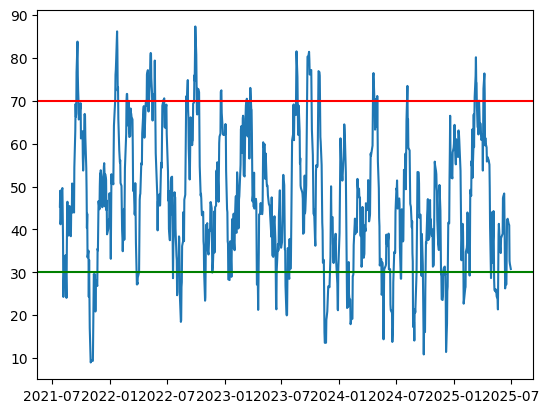

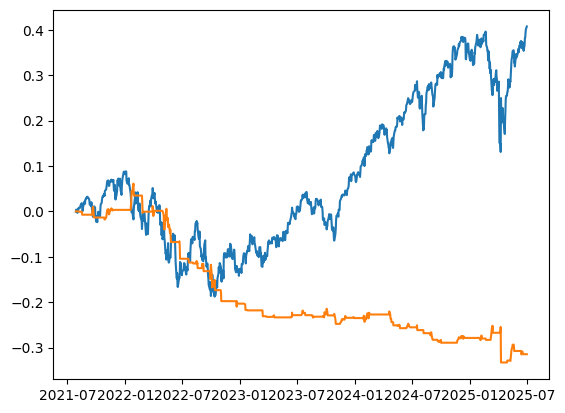

In [ ]:
# The Money Flow Index (MFI) is a momentum oscillator that uses both price and volume 
# to measure buying and selling pressure over a given period. Unlike the RSI, which 
# considers only price changes, the MFI incorporates volume to gauge the strength 
# of money flowing in and out of a security. It ranges between 0 and 100, with values 
# above 80 typically indicating overbought conditions (potential reversal or pullback) 
# and values below 20 suggesting oversold conditions (potential rebound). This makes 
# it a useful tool for spotting divergences, overbought/oversold levels, and confirming 
# price trends.


# TP = (high+low+close)/3
# MF = TP*Volume, estimate how much capital flowed in or out that day. A high-volume up day implies stronger buying pressure than a low-volume one.
# PMF = Sum of MF for all up days in period
# NMF  = sum of MF for all down days in period
# MR = PMF/NMF
# MFI = 100 - (100)/(1+MR)


TICKER = 'SPY'
MFI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):
    df = yf.download(
        ticker,
        start='1993-01-29',
        end='2025-07-01',
        interval='1d',
        auto_adjust=False,
        progress=False,
        threads=False
    )
    df.columns = df.columns.get_level_values(0)
    return df.dropna().iloc[-lookback:, :]



def add_MFI(df, length = MFI_LENGTH):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume']*df['Average_Price']

    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    #define pos and neg flow values based on previous price
    df['Pos_Flow'] = np.where(df['Average_Price'].diff()>0,df['Money_Flow'],0) #flowing in (buying pressure)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff()<0,df['Money_Flow'],0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    #add money flow column
    df['MFI'] = 100-((100/(1+mfr)))

    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color = 'red') # # above red: overbought, potential short
    plt.axhline(OVERSOLD, color = 'green') # # below green: oversold, potential long
    

    return df.dropna()


def add_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):

    df.columns = df.columns.get_level_values(0)

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MFI']>overbought,-1,
                              np.where(df['MFI']<oversold,1,0))
    df['Strategy'] = df['Strategy'].shift(1)

    return df.dropna()



def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change()*df['Strategy']).cumprod() - 1
    

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    return df



def main():
    df = get_data()
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df